### Import Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Load Data

In [2]:
groundtruth_dir = 'Data/clean_data/'  
groundtruth_data = []


for file_name in os.listdir(groundtruth_dir):
    if file_name.endswith('.json'):
        with open(os.path.join(groundtruth_dir, file_name), 'r') as file:
            for line in file:
                try:
                    entry = json.loads(line)
                    # Extract trip_id and time (ground truth)
                    groundtruth_data.append({
                        'trip_id': entry['trip_id'],
                        'actual_eta': entry['time']  
                    })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in {file_name}: {e}")


groundtruth_df = pd.DataFrame(groundtruth_data)

In [ ]:
# Load RFR and XGBoost prediction files
rfr_predictions = pd.read_csv('Model Predictions/rfr_predictions.csv')  
xgb_predictions = pd.read_csv('Model Predictions/xgboost_predictions.csv')  

xgb_predictions.rename(columns={'predicted_eta': 'xgb_time'}, inplace=True)

if 'segment_id' in rfr_predictions.columns:
    rfr_pivot = rfr_predictions.pivot_table(index='trip_id', columns='segment_id', values='predicted_eta').reset_index()

    # Rename columns for each trip segment
    rfr_pivot.columns = ['trip_id', 'rfr_time_1', 'rfr_time_3']
else:
    raise KeyError("'segment_id' column not found in rfr_predictions. Ensure it exists.")

# Merge the RFR and XGBoost predictions with ground truth data
combined_df = (
    pd.merge(rfr_pivot, xgb_predictions[['trip_id', 'xgb_time']], on='trip_id', how='inner')
    .merge(groundtruth_df, on='trip_id', how='inner')
)

combined_df['total_predicted_eta'] = combined_df['rfr_time_1'] + combined_df['rfr_time_3'] + combined_df['xgb_time']

In [11]:
combined_df.isnull().sum()

trip_id       0
rfr_time_1    0
rfr_time_3    0
xgb_time      0
actual_eta    0
total_eta     0
dtype: int64

In [9]:
# drop rows where rfr_time_3 is null
combined_df = combined_df.dropna(subset=['rfr_time_3'])

In [10]:
# fill missing values (segment 1) with the 0 
combined_df = combined_df.fillna(0)

### Modeling

In [ ]:
X = combined_df[['rfr_time_1', 'rfr_time_3', 'xgb_time']]  
y = combined_df['actual_eta']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Meta-model training
meta_model = LinearRegression()
meta_model.fit(X_train, y_train)

y_pred = meta_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Meta-Model Metrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}\n")

# Save the combined results with predicted ETA to a CSV file
combined_df['final_predicted_eta'] = meta_model.predict(X)
combined_df.to_csv('Model Predictions/final_predictions.csv', index=False)
print("Stacked ETA predictions saved to 'meta_predictions.csv\n")

print(combined_df.head())

Meta-Model Metrics:
RMSE: 314.98610768198847
MAE: 236.42650956759164
R² Score: 0.7726370323356879

Stacked ETA predictions saved to 'meta_predictions.csv
'
                                             trip_id  rfr_time_1   rfr_time_3  \
0  007369e0b92ec0b0d2a35076b44680ed83efb79be45a6d...  353.813450   698.024965   
1  008a46a649e0ea25961230e46717049db2ae550f39f694...  116.211975   683.395779   
2  00a8a1894f7525143aa5ae66c46f635f23e4e7b33f5244...  770.387866  1478.905457   
3  00b2f22afb76f4867f0ec9b2d87a2d3573d885a0c2536c...    0.000000   496.915176   
4  00fcdbd4f719690ec80fdc37232b6c524f1a912c157627...    0.000000   924.242396   

     xgb_time  actual_eta    total_eta  predicted_eta  
0   666.64343      1314.0  1718.481845    1814.133628  
1  1033.84730      2199.0  1833.455054    2146.026983  
2   887.48846      2959.0  3136.781783    2977.873298  
3   515.82050      1339.0     0.000000    1284.281796  
4   631.38184      1535.0     0.000000    1809.322536  


### Feature Importance

Feature Importance for Linear Regression Model:
      feature  coefficient
2    xgb_time     1.238183
1  rfr_time_3     0.893823
0  rfr_time_1     0.461681


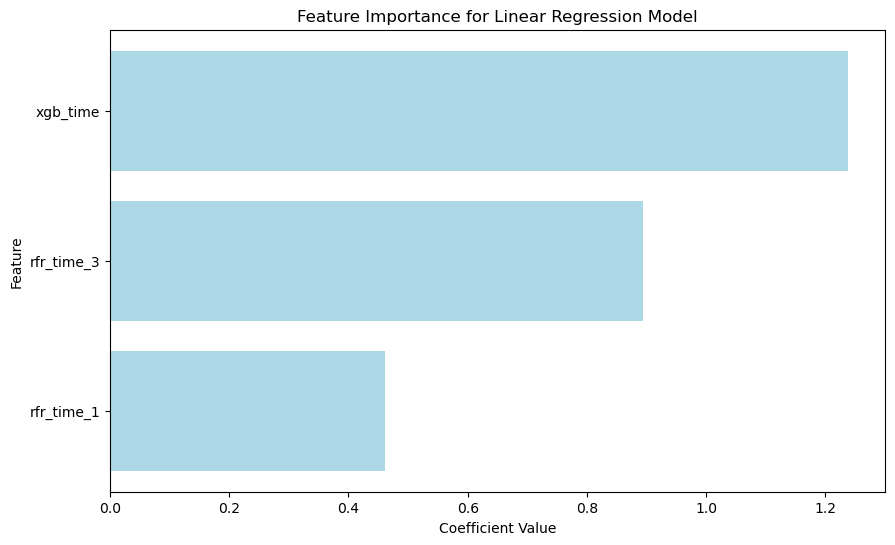

In [14]:
# Get the feature coefficients from the trained meta-model
coefficients = meta_model.coef_


feature_importance_df = pd.DataFrame({
    'feature': X.columns,  
    'coefficient': coefficients
})

# Sort by the absolute value of coefficients for better interpretation
feature_importance_df['abs_coefficient'] = np.abs(feature_importance_df['coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='abs_coefficient', ascending=False)

# Display the feature importance
print("Feature Importance for Linear Regression Model:")
print(feature_importance_df[['feature', 'coefficient']])


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Meta-Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
